In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopy
from geopy.distance import vincenty
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import sklearn
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import explained_variance_score, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import shap
import pickle
import xgboost as xgb
from xgboost import plot_importance

%matplotlib inline

/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
df = pd.read_pickle('processed_data.pkl')

In [3]:
df.head()

,listing_url,id,host_response_time,host_response_rate,host_is_superhost,host_neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,...,Bathtub with bath chair,Handheld shower head,Table corner guards,Smoking allowed,lat_long,palace_dist,ginza_dist,temple_dist,park_dist,skytree_dist
0,https://www.airbnb.com/rooms/197677,197677,within a day,100.0,1,Sumida District,Sumida Ku,35.71721,139.82596,Apartment,...,0,0,0,0,"(35.717209999999994, 139.82596)",7513.579496,7417.810752,2661.084760,4696.409605,1590.312028
1,https://www.airbnb.com/rooms/776070,776070,within an hour,100.0,1,Kita District,Arakawa Ku,35.73818,139.77009,House,...,0,0,0,0,"(35.73818, 139.77008999999998)",6082.978847,7438.766049,3539.136814,2542.453677,4817.368015
2,https://www.airbnb.com/rooms/905944,905944,within an hour,95.0,1,Shibuya District,Shibuya Ku,35.67968,139.67949,Apartment,...,0,0,0,0,"(35.67968, 139.67949)",6664.499962,7933.153958,11301.364119,9440.211966,12346.096121
3,https://www.airbnb.com/rooms/1016831,1016831,within a few hours,100.0,1,Shimokitazawa,Setagaya Ku,35.65833,139.67153,House,...,0,0,0,0,"(35.65833, 139.67153000000002)",7938.897330,8716.697715,12947.277243,11244.471333,13845.629774
4,https://www.airbnb.com/rooms/1096292,1096292,within a day,100.0,1,Shinjuku District,Shinjuku Ku,35.69098,139.70618,House,...,0,0,0,0,"(35.690979999999996, 139.70618000000002)",4268.373312,5885.015482,8607.893109,6721.937428,9694.372231


## Model Preparation

In [4]:
model1 = df[(df['price'] < 150) & (df['accommodates'] <= 10)]

In [5]:
drop_cols = ['listing_url', 'id', 'host_response_time', 'neighbourhood_cleansed',
             'amenities', 'availability_30', 'availability_365', 'has_availability',
             'last_scraped', 'last_review', 'price', 'booked_days', 'monthly_revenue', 'lat_long'
            ]

X = model1.copy()
y = X['price']
X.drop(columns=drop_cols, inplace=True)
final_cols = X.columns.tolist()
#X.drop(X.columns[[29]], axis=1, inplace=True)
X = pd.get_dummies(X, drop_first=True)

In [6]:
drop_feats2 = ['beds',
 'translation missing: en.hosting_amenity_50',
 'translation missing: en.hosting_amenity_49',
 'review_scores_accuracy',
 'review_scores_communication',
 'num_amenities',
 'Air purifier',
 'Toilet paper',
 'Fireplace guards',
 'Soaking tub',
 'Cable TV',
 'Lockbox',
 'Table corner guards',
 'Baby monitor',
 'No stairs or steps to enter',
 'Luggage dropoff allowed',
 'Dog(s)',
 'Wide hallways',
 'Fixed grab bars for shower',
 'First aid kit',
 'Flat path to guest entrance',
 'Wide entrance',
 'Bedroom comforts',
 'Cat(s)',
 'Walk-in shower',
 'Hot water kettle',
 'Free street parking',
 'Suitable for events',
 'Pets live on this property',
 'Terrace',
 'Other pet(s)',
 'Accessible-height toilet',
 'Lake access',
 'Balcony',
 'Carbon monoxide detector',
 'Ground floor access',
 'Beachfront',
 'Hair dryer',
 'Crib',
 'EV charger',
 'Wheelchair accessible',
 'Stair gates',
 'Memory foam mattress',
 'Kitchenette',
 'Family/kid friendly',
 'Private living room',
 'Extra space around bed',
 'Wide doorway to guest bathroom',
 'Breakfast table',
 'Bathtub with bath chair',
 'Roll-in shower',
 'Smart TV',
 'Children’s dinnerware',
 'Mobile hoist',
 'Essentials',
 'Well-lit path to entrance',
 'Changing table',
 'temple_dist',
 'park_dist',
 'skytree_dist',
 'host_neighbourhood_Akasaka',
 'host_neighbourhood_Chiyoda District',
 'host_neighbourhood_Chūō District',
 'host_neighbourhood_Edogawa District',
 'host_neighbourhood_Ikuno-ku',
 'host_neighbourhood_Kita District',
 'host_neighbourhood_Kita-ku',
 'host_neighbourhood_Minami-ku',
 'host_neighbourhood_Nakameguro',
 'host_neighbourhood_Nakano District',
 'host_neighbourhood_Nanfang Shangcheng',
 'host_neighbourhood_Nishi-ku',
 'host_neighbourhood_Setagaya District',
 'host_neighbourhood_Shinagawa District',
 'host_neighbourhood_Soho',
 'host_neighbourhood_Toshima District',
 'property_type_Dome house',
 'property_type_Hotel',
 'property_type_Other',
 'bed_type_Futon',
 'bed_type_Pull-out Sofa',
 'bed_type_Real Bed', 
 'host_response_rate', 'extra_people',
 'minimum_nights',
 'maximum_nights',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'reviews_per_month',
 'since_last_review',
 'palace_dist',
 'ginza_dist',
 'temple_dist',
 'park_dist',
 'skytree_dist',
  'latitude', 'longitude']

In [7]:
X.drop(columns=drop_feats2, inplace=True)
#X.drop(X.columns[[6]], axis=1, inplace=True)

In [8]:
cols = [x.lower() for x in X.columns.tolist()]
X.columns = cols

In [9]:
df2 = X.copy()
y_copy = y.copy()

In [10]:
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)

In [11]:
print(f' X_train shape : {X_train.shape}')
print(f' X_val shape : {X_val.shape}')
print(f' X_test shape : {X_test.shape}')

 X_train shape : (2544, 132)
 X_val shape : (848, 132)
 X_test shape : (849, 132)


## OLS

In [12]:
X_train.head()

,host_is_superhost,accommodates,bathrooms,bedrooms,security_deposit,guests_included,neg_score,neu_score,pos_score,,...,host_neighbourhood_tsukishima,host_neighbourhood_yodogawa-ku,property_type_condominium,property_type_hostel,property_type_house,property_type_ryokan (japan),property_type_serviced apartment,room_type_hotel room,room_type_private room,room_type_shared room
4491,0,4,1.0,1.0,0.0,2,0.0,0.286,0.714,1,...,0,0,0,0,0,0,0,0,0,0
3678,1,5,1.0,2.0,184.0,3,0.0,1.000,0.000,1,...,0,0,0,0,0,0,0,0,0,0
3336,0,4,1.5,0.0,184.0,2,0.0,0.743,0.257,1,...,0,0,0,0,0,0,0,0,0,0
4674,0,4,1.0,1.0,0.0,1,0.0,0.906,0.094,1,...,0,0,0,0,0,0,0,0,0,0
4195,0,6,1.0,2.0,184.0,4,0.0,1.000,0.000,1,...,0,0,0,0,0,0,0,0,0,0


In [13]:
std = StandardScaler() 
std.fit(X_train.values) 
X_train_scaled = std.transform(X_train.values)
train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
model = sm.OLS(np.array(y_train), sm.add_constant(train_df))

fit = model.fit()
fit.summary()

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     23.73
Date:                Mon, 17 Feb 2020   Prob (F-statistic):               0.00
Time:                        17:00:53   Log-Likelihood:                -11557.
No. Observations:                2544   AIC:                         2.337e+04
Df Residuals:                    2417   BIC:                         2.411e+04
Df Model:                         126                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                     82.2719      0.463    177.874      0.000      81.365      83.179
host_is_superhost                          4.6411      0.561      8.276      0.000       3.541       5.741
accommodates                               7.6023      0.701     10.851      0.000       6.228       8.976
bathrooms                                  0.3232      0.558      0.580      0.562      -0.770       1.417
bedrooms                                   0.7908      0.614      1.288      0.198      -0.413       1.995
security_deposit                           2.9358      0.516      5.690      0.000       1.924       3.948
guests_included                            5.6549      0.635      8.902      0.000       4.409       6.901
neg_score                                  1.4095      0.871      1.617      0.106      -0.299       3.118
neu_score                                 10.2636      5.168      1.986      0.047       0.129      20.398
pos_score                                 11.5710      5.160      2.242      0.025       1.453      21.689
                                       -5.222e-14   2.69e-14     -1.942      0.052   -1.05e-13    5.01e-16
window guards                             -0.9985      0.550     -1.816      0.069      -2.076       0.079
elevator                                   4.0943      0.550      7.440      0.000       3.015       5.173
refrigerator                              -2.5238      1.073     -2.352      0.019      -4.628      -0.420
cleaning before checkout                   0.3029      0.539      0.562      0.574      -0.755       1.360
paid parking on premises                   0.3892      0.520      0.748      0.454      -0.631       1.409
heating                                   -0.1189      0.509     -0.234      0.815      -1.117       0.879
coffee maker                               0.7123      0.545      1.307      0.191      -0.356       1.781
building staff                            -2.2652      0.585     -3.870      0.000      -3.413      -1.117
buzzer/wireless intercom                  -0.7542      0.556     -1.356      0.175      -1.845       0.336
bathtub                                   -0.7963      0.597     -1.333      0.183      -1.968       0.375
shower chair                              -1.6411      0.560     -2.928      0.003      -2.740      -0.542
host greets you                           -2.4170      0.594     -4.068      0.000      -3.582      -1.252
roll-in shower with chair                  0.6276      0.510      1.230      0.219      -0.373       1.628
pocket wifi                                0.9938      0.641      1.550      0.121      -0.264       2.251
long term stays allowed                   -1.5200      0.599     -2.536      0.011     

## Problems with Insignificant Features

One of the problems with just parsing amenities and adding them as features is that a lot of them can actually be useless in helping the model's predictive ability. This is in fact reflected if we take a look at the statsmodels summary above, where many features have a high p-value which suggests that this specific feature is not really associated with changes in our target variable.

We can choose to either manually get rid of these insignificant features or use lasso to do the heavy lifting for us.

In [14]:
selected_cols = ['host_is_superhost', 'accommodates', 'bathrooms', 'bedrooms', 'security_deposit',
                 'guests_included', 'shampoo', 'wifi', 'elevator', 'long term stays allowed',
                 'tv', 'shower chair', 'refrigerator', 'smart lock', 'self check-in', 
                 'smoking allowed', 'oven', 'lock on bedroom door', 'private entrance',
                 'building staff', 'breakfast', 'laptop friendly workspace',
                 'washer', 'free parking on premises', 'host greets you', 'host_neighbourhood_arakawa district',
                 'host_neighbourhood_itabashi district', 'host_neighbourhood_katsushika district',
                 'host_neighbourhood_konohana-ku', 'host_neighbourhood_koto district', 
                 'host_neighbourhood_meguro district', 'host_neighbourhood_minato district',
                 'host_neighbourhood_miyakojima-ku', 'host_neighbourhood_naniwa-ku', 
                 'host_neighbourhood_ota district', 'host_neighbourhood_roppongi',
                 'host_neighbourhood_shibuya', 'host_neighbourhood_shimokitazawa',
                 'host_neighbourhood_shinjuku', 'host_neighbourhood_shinjuku district',
                 'host_neighbourhood_suginami district', 'host_neighbourhood_sumida district',
                 'host_neighbourhood_tsukiji', 'host_neighbourhood_tsukishima',
                 'property_type_hostel', 'property_type_house', 
                 'property_type_serviced apartment', 'room_type_hotel room', 'room_type_private room',
                 'room_type_shared room', 'dishes and silverware'       
                
                ]

## OLS After Removing Features

In [15]:
X = df2[selected_cols]

In [16]:
copy = X.copy()
copy['price'] = y_copy

copy.to_pickle('cleaned_df.pkl')

In [17]:
X, X_test, y, y_test = train_test_split(X, y_copy, test_size=.2, random_state=10)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)

In [18]:
std = StandardScaler() 
std.fit(X_train.values) 
X_train_scaled = std.transform(X_train.values)
X_val_scaled = std.transform(X_val.values)
X_test_scaled = std.transform(X_test.values)

train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
model = sm.OLS(np.array(y_train), sm.add_constant(train_df))

fit = model.fit()
fit.summary()

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     53.67
Date:                Mon, 17 Feb 2020   Prob (F-statistic):               0.00
Time:                        17:00:54   Log-Likelihood:                -11639.
No. Observations:                2544   AIC:                         2.338e+04
Df Residuals:                    2492   BIC:                         2.369e+04
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                     82.2719      0.470    174.933      0.000      81.350      83.194
host_is_superhost                          4.6534      0.532      8.750      0.000       3.611       5.696
accommodates                               7.5063      0.688     10.915      0.000       6.158       8.855
bathrooms                                  0.3720      0.548      0.678      0.498      -0.703       1.447
bedrooms                                   0.5777      0.603      0.958      0.338      -0.605       1.760
security_deposit                           2.8066      0.500      5.612      0.000       1.826       3.787
guests_included                            5.8404      0.607      9.629      0.000       4.651       7.030
shampoo                                    0.9718      0.482      2.017      0.044       0.027       1.917
wifi                                       1.5109      0.504      2.997      0.003       0.522       2.499
elevator                                   3.7718      0.533      7.079      0.000       2.727       4.817
long term stays allowed                   -1.8930      0.523     -3.622      0.000      -2.918      -0.868
tv                                         1.4488      0.517      2.801      0.005       0.435       2.463
shower chair                              -0.9731      0.492     -1.976      0.048      -1.938      -0.008
refrigerator                              -3.2042      0.761     -4.212      0.000      -4.696      -1.713
smart lock                                 1.9618      0.499      3.932      0.000       0.983       2.940
self check-in                             -2.0376      0.556     -3.662      0.000      -3.129      -0.946
smoking allowed                           -1.7006      0.493     -3.450      0.001      -2.667      -0.734
oven                                      -1.6796      0.503     -3.338      0.001      -2.666      -0.693
lock on bedroom door                      -2.3044      0.533     -4.324      0.000      -3.349      -1.259
private entrance                           3.4779      0.514      6.762      0.000       2.469       4.486
building staff                            -2.5253      0.543     -4.654      0.000      -3.589      -1.461
breakfast                                  1.2457      0.491      2.536      0.011       0.282       2.209
laptop friendly workspace                  1.8192      0.510      3.567      0.000       0.819       2.819
washer                                    -1.2937      0.518     -2.496      0.013      -2.310      -0.277
free parking on premises                  -1.2230      0.482     -2.535      0.011      -2.169      -0.277
host greets you                           -2.7673      0.544     -5.088      0.000     

## Scikit-Learn Regression

In [19]:
def mae_score(pred, actual):
    return np.mean(np.abs(np.exp(actual) - np.exp(pred)))

In [20]:
lm = LinearRegression() 

lm.fit(X_train_scaled, y_train)

train_pred = lm.predict(X_train_scaled)
val_pred = lm.predict(X_val_scaled)

print(f'Linear Regression train R^2: {lm.score(X_train_scaled, y_train)}')
print(f'Linear Regression val R^2: {lm.score(X_val_scaled, y_val)}')

print("\nTraining MAE:", round(mean_absolute_error(y_train, train_pred),4))
print("Validation MAE:", round(mean_absolute_error(y_val, val_pred),4))

Linear Regression train R^2: 0.5234385194012572
Linear Regression val R^2: 0.46169247385958634

Training MAE: 18.3388
Validation MAE: 20.2448


In [21]:
y_train.describe()

count    2544.000000
mean       82.271904
std        34.015779
min         9.926800
25%        55.586400
50%        82.395200
75%       110.188400
max       149.895600
Name: price, dtype: float64

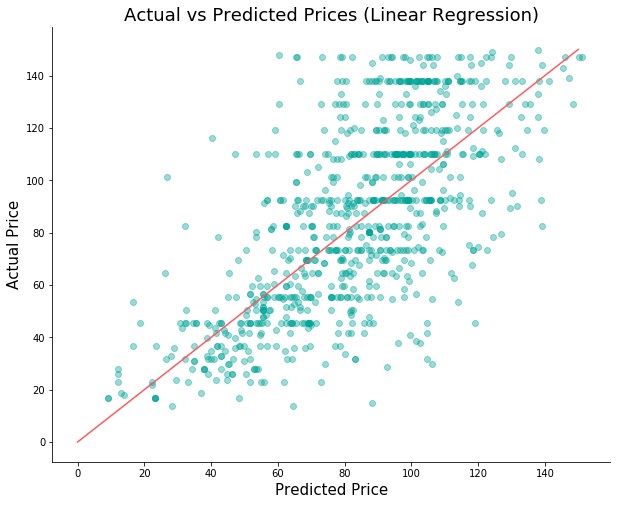

In [22]:
# Plot actual vs predicted
plt.figure(figsize=(10, 8))
plt.plot([0,150], [0,150], c='#FF5A5F')
plt.scatter(val_pred, y_val, color='#00A699', alpha=0.4)
sns.despine()
plt.ylabel('Actual Price', size=15)
plt.xlabel('Predicted Price', size=15)
plt.title('Actual vs Predicted Prices (Linear Regression)', size=18);
plt.savefig('actual_plot', bbox_inches ='tight', dpi = 400)

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


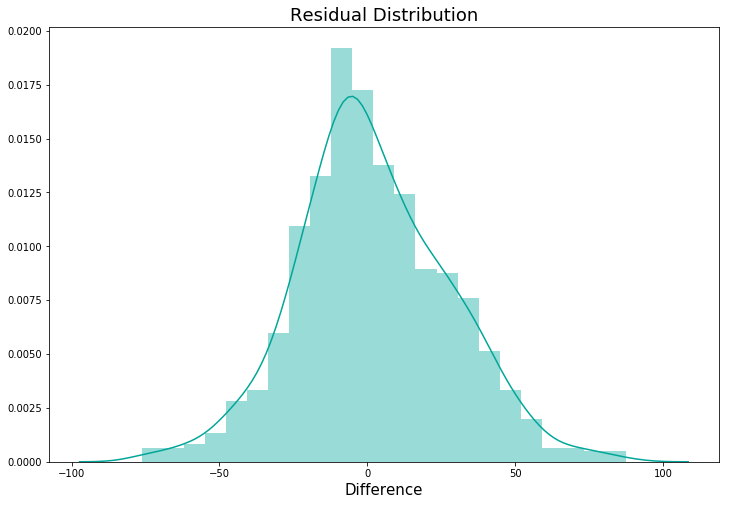

In [23]:
plt.figure(figsize=(12,8))
sns.distplot(y_val - val_pred, color='#00A699') 
plt.title('Residual Distribution', size = 18)
plt.xlabel('Difference', size = 15);
plt.savefig('residuals', bbox_inches ='tight', dpi = 400);

## Regularization

### Lasso Regression

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state = 21)

alphavec = 10**np.linspace(-3,3,500)

lasso_model = LassoCV(alphas = alphavec, cv=kf)

lasso_model.fit(X_train_scaled, y_train)

print('LassoCV alpha:', lasso_model.alpha_)

print(f'LassoCV train R^2: {lasso_model.score(X_train_scaled, y_train):.3f}')
print(f'LassoCV val R^2: {lasso_model.score(X_val_scaled, y_val):.3f}')

train_pred = lasso_model.predict(X_train_scaled)
y_val_pred = lasso_model.predict(X_val_scaled)

print('Train MAE for LassoCV:', round(mean_absolute_error(y_train, train_pred),4))
print('Validation MAE for LassoCV:', round(mean_absolute_error(y_val, y_val_pred),4))

In [ ]:
# Plot actual vs predicted
plt.figure(figsize=(10, 8))
plt.plot([0,150], [0,150], c='#FF5A5F')
plt.scatter(y_val_pred, y_val, color='#00A699', alpha=0.4)
sns.despine()
plt.ylabel('Actual Price', size=15)
plt.xlabel('Predicted Price', size=15)
plt.title('Actual vs Predicted Prices (Lasso)', size=18);
plt.savefig('actual plot', bbox_inches ='tight', dpi = 400)

### Ridge Regression

In [ ]:
alphavec = 10**np.linspace(-3,3,500)

ridge_model = RidgeCV(alphas = alphavec, cv=kf)

ridge_model.fit(X_train_scaled, y_train)

print('LassoCV alpha:', ridge_model.alpha_)

print(f'LassoCV train R^2: {ridge_model.score(X_train_scaled, y_train):.3f}')
print(f'LassoCV val R^2: {ridge_model.score(X_val_scaled, y_val):.3f}')

train_pred = ridge_model.predict(X_train_scaled)
y_val_pred = ridge_model.predict(X_val_scaled)

print('Train MAE for LassoCV:', round(mean_absolute_error(y_train, train_pred),4))
print('Validation MAE for LassoCV:', round(mean_absolute_error(y_val, y_val_pred),4))

### Linear Regression Coefficients

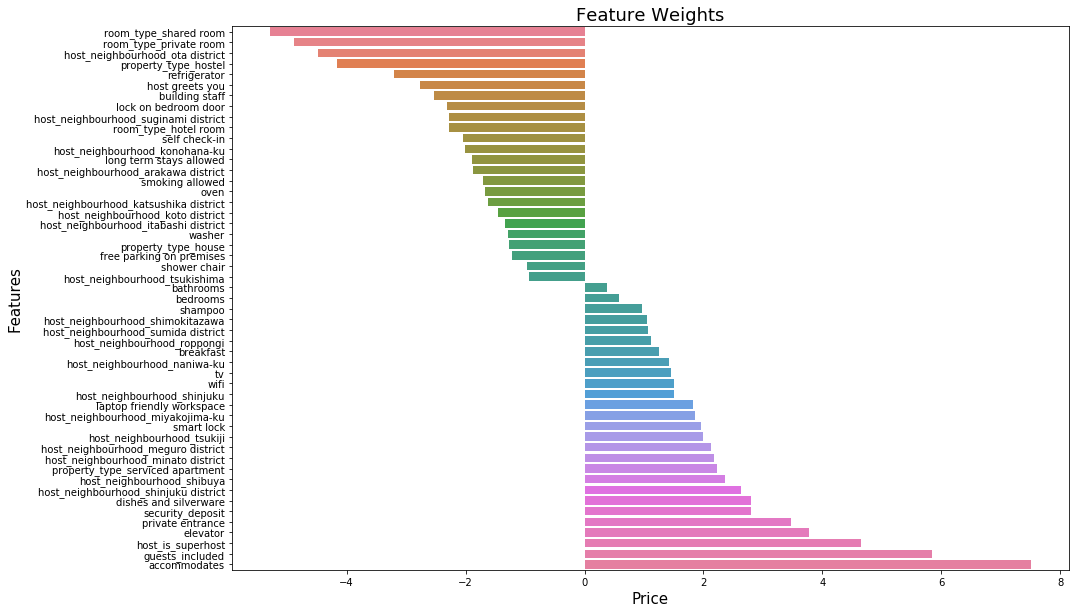

In [29]:
coef_list = sorted(list(zip(X_train.columns, lm.coef_)), key= lambda x : x[1])

x_values = [x[0] for x in coef_list]
y_values = [y[1] for y in coef_list]

fig, ax = plt.subplots(figsize=(15,10))
ax = sns.barplot(x=y_values, y=x_values, palette=("husl"))
#ax.set(xticks=xtick_list)
ax.set_title('Feature Weights', size=18)
ax.set_xlabel('Price', size=15)
ax.set_ylabel('Features', size=15)
plt.savefig('features', bbox_inches ='tight', dpi = 400)

In [ ]:
x_values

In [25]:
coefs_df = pd.DataFrame(columns=['Feature', 'Coefficient'])
coefs_df['Feature'] = x_values
coefs_df['Coefficient'] = y_values
coefs_df.to_csv('lr_coefs.csv')
coefs_df

,Feature,Coefficient
0,room_type_shared room,-5.288831
1,room_type_private room,-4.879638
2,host_neighbourhood_ota district,-4.478610
3,property_type_hostel,-4.169036
4,refrigerator,-3.204207
5,host greets you,-2.767319
6,building staff,-2.525296
7,lock on bedroom door,-2.304375
8,host_neighbourhood_suginami district,-2.275036
9,room_type_hotel room,-2.271857


In [26]:
actionable_feats = ['host_is_superhost', 'smart lock', 'laptop_friendly_workspace',
                    'tv', 'wifi', 'breakfast', 'shampoo', 'dishes and silverware']

coefs = coefs = sorted(list(zip(lm.coef_, X.columns)))

coefs = coefs[::-1]
improvements = [x for x in coefs if x[1] in actionable_feats]

improvements

[(4.653386445020081, 'host_is_superhost'),
 (2.8024354722479354, 'dishes and silverware'),
 (1.9618336399195393, 'smart lock'),
 (1.5108581720357304, 'wifi'),
 (1.448761441546885, 'tv'),
 (1.2457141547175083, 'breakfast'),
 (0.9718034143966281, 'shampoo')]

In [27]:
import matplotlib.style as style 


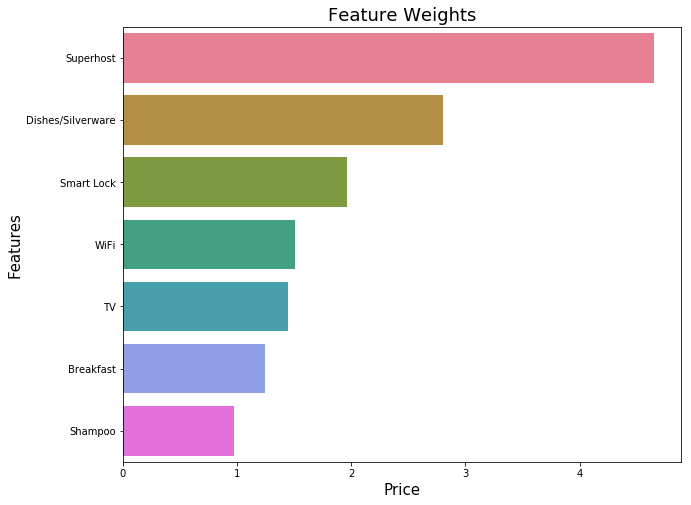

In [28]:
x_values = [x[0] for x in improvements]
y_values = [y[1] for y in improvements]

xtick_list = ['Superhost', 'Dishes/Silverware', 'Smart Lock', 'WiFi', 'TV', 'Breakfast', 'Shampoo']
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.barplot(x=x_values, y=y_values, palette=("husl"))
#ax.set(xticks=xtick_list)
ax.set_title('Feature Weights', size=18)
ax.set_xlabel('Price', size=15)
ax.set_yticklabels(xtick_list, size=10)
ax.set_ylabel('Features', size=15)
plt.savefig('features', bbox_inches ='tight', dpi = 400)

In [ ]:
fig, ax = plt.subplots(figsize=(10,5)) 
model1['price'].hist(color='#FF585D')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Number of Listings');

plt.savefig('price', bbox_inches ='tight', dpi = 400)

## XGBoost

In [ ]:
eval_set = [(X_val, y_val)]

In [ ]:
gbm = xgb.XGBRegressor( 
                       n_estimators=10000, #arbitrary large number
                       max_depth=7,
                       objective="reg:squarederror",
                       learning_rate=.1, 
                       subsample=1,
                       min_child_weight=1,
                       colsample_bytree=.6
                      )

eval_set=[(X_train,y_train),(X_val,y_val)] #tracking train/validation error as we go

xgb_reg = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='mae',
                    early_stopping_rounds=20,
                    verbose=100 #gives output log as below
                   )

In [ ]:
test_pred = xgb_reg.predict(X_test)
print('Test MAE:', round(mean_absolute_error(y_test, test_pred),4))

## GridSearchCV for Best Parameters

In [ ]:
from sklearn.model_selection import GridSearchCV

xgb_param_grid = {
    'max_depth': [5, 7, 9],
    'learning_rate': [0.1],
    'n_estimators': [1000],
    'colsample_bytree':[0.5,0.75],
    'colsample_bylevel':[0.25,0.5],  
}

xgb_gridsearch = GridSearchCV(xgb.XGBRegressor(),
                           xgb_param_grid,
                           cv=5,
                           n_jobs=-1)

xgb_gridsearch.fit(X_train, y_train)


In [ ]:
best_xgb = xgb_gridsearch.best_estimator_


In [ ]:
test_pred = best_xgb.predict(X_test)
print('Test MAE:', round(mean_absolute_error(y_test, test_pred),4))

In [ ]:
best_xgb

In [ ]:
pickle.dump(best_xgb, open("best_xgb_model.pkl", "wb"))

In [ ]:
feat_df = pd.DataFrame(list(zip(X_train.columns, best_xgb.feature_importances_)), 
                       columns=['Feature', 'Weight'])

In [ ]:
feat_df = feat_df.sort_values(by=['Weight'], ascending=False)

In [ ]:
top_10 = feat_df.head(10)

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.barplot(x=top_10['Weight'], y=top_10['Feature'])
ax.set_title('XGBoost Feature Importances');

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_train)

In [ ]:
shap.summary_plot(shap_values, X_train,max_display=30)

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[113,:], X_test.iloc[10,:]) 


In [ ]:
shap.dependence_plot("accommodates", shap_values, X_train)

In [ ]:
X_display, y_display = shap.datasets.adult(display=True)

In [ ]:
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

In [ ]:
select = range(20,50)
features = X_test.iloc[select]
features_display = X_test.iloc[select]

In [ ]:
shap_values = explainer.shap_values(features)[1]

In [ ]:
shap.decision_plot(expected_value, shap_values, features_display)